In [48]:
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn
from PIL import Image
import os

In [49]:
from skimage import filters, color, morphology, io
import matplotlib.pyplot as plt
import numpy as np
import random
import skimage as si

from google.colab import auth
from google.colab import drive

import gspread

from google.auth import default
from PIL import Image

#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


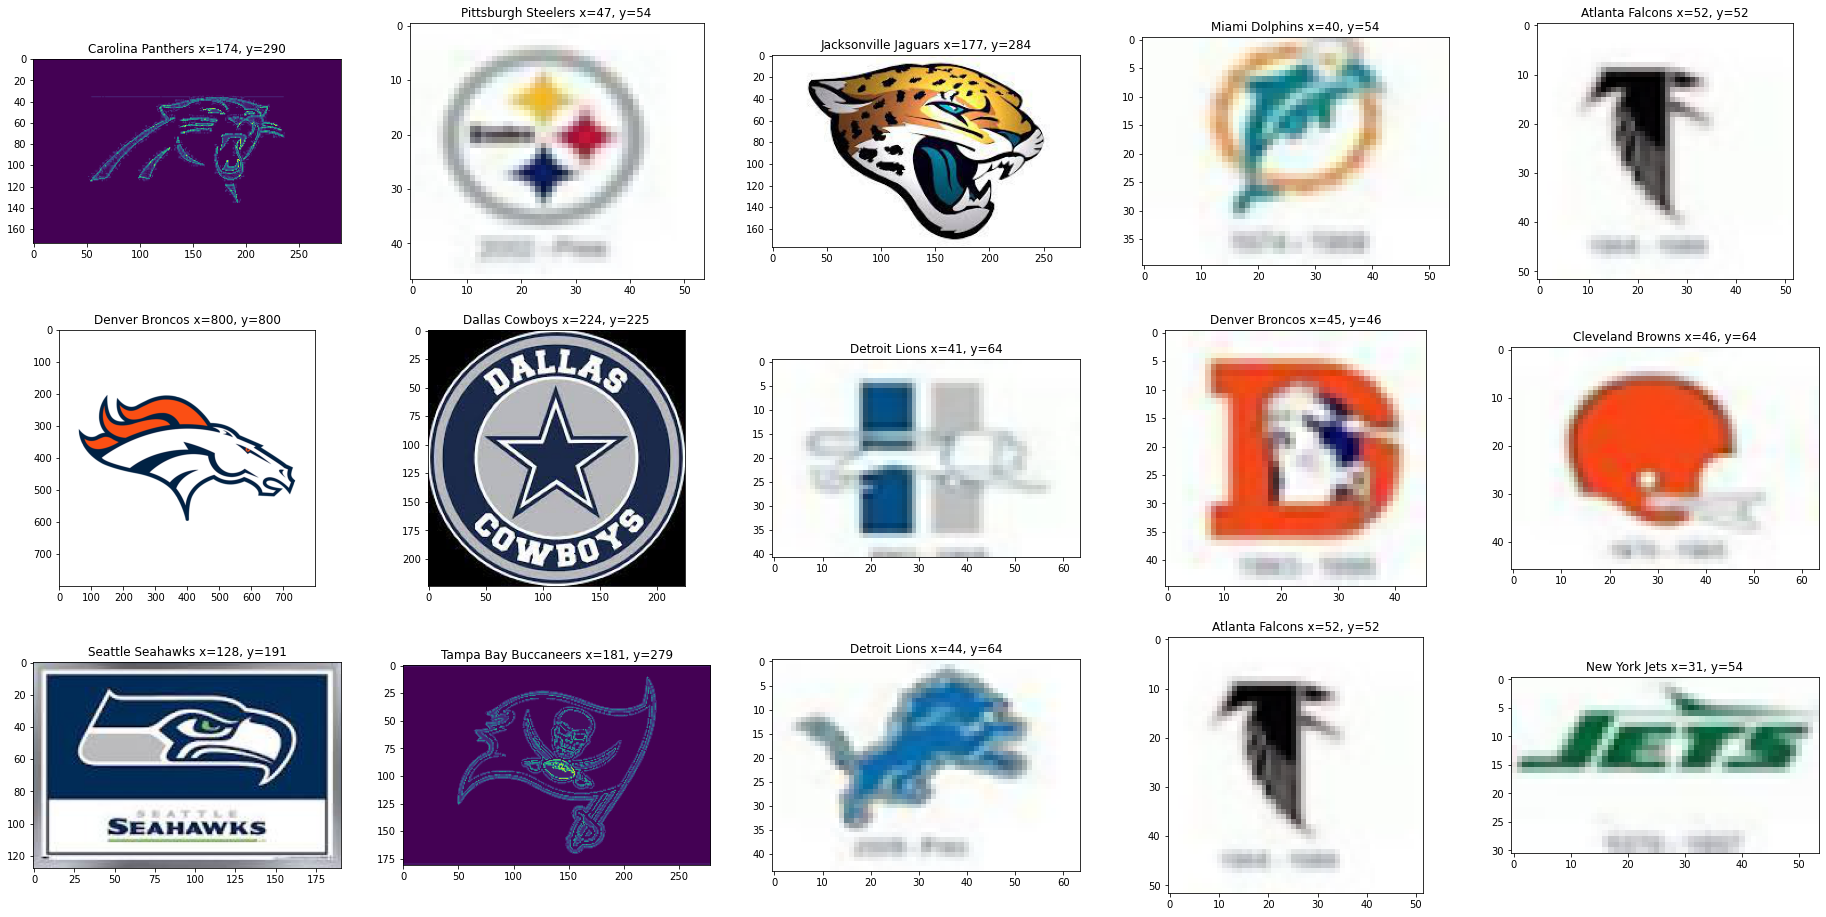

In [50]:
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1eNgK86cm6L1OVI5iavk7mY3UQUd1VHeXgwXSTyNNuRw/edit?usp=sharing')
ws = sh.worksheet('train')

df = pd.DataFrame(ws.get_all_records())

n1 = 3
n2 = 5

fig, axs = plt.subplots(n1, n2, figsize=(32, 16))

for i in range(n1):
  for j in range(n2):
    z = random.randint(0, len(df)-1)
    pic = np.array(Image.open(df.loc[z]["filepath"]))
    shape = np.shape(pic)
    axs[i, j].imshow(pic)
    axs[i, j].set_title('%s x=%.f, y=%.f' % (df.loc[z]["team_name"], shape[0], shape[1]))

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Average height 385.6666666666667


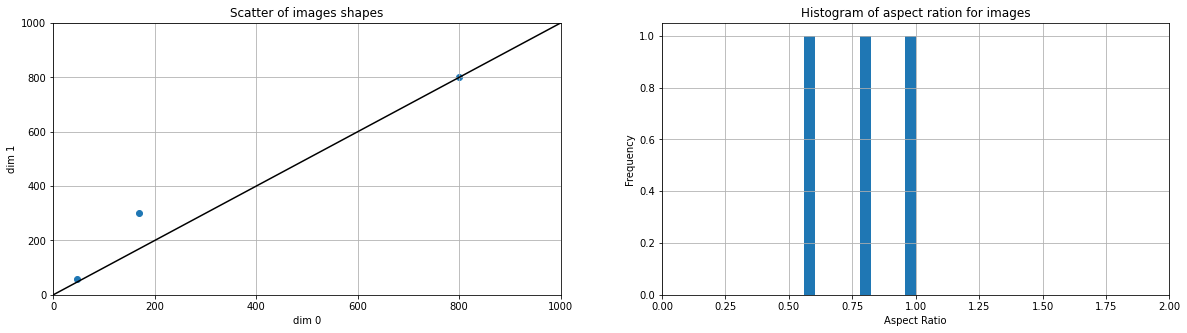

In [51]:
import numpy as np

sample_df = df.sample(frac=0.01, ignore_index=True)

N = len(sample_df)
shape = np.zeros((2, N))

for i in range(N):    
    tmp = np.shape(np.array(Image.open(sample_df.loc[i]["filepath"]).convert('L')))
    shape[:, i] = [tmp[0], tmp[1]]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(shape[0, :], shape[1, :])
axs[0].plot(range(0, 1000), range(0, 1000), 'k')
axs[0].set_ylabel('dim 1')
axs[0].set_xlabel('dim 0')
axs[0].grid()
axs[0].set_title('Scatter of images shapes')
axs[0].set_xlim([0, 1000])
axs[0].set_ylim([0, 1000])

axs[1].hist(shape[0, :]/shape[1, :])
axs[1].grid()
axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of aspect ration for images')
axs[1].set_xlim([0, 2])

print("Average height " + str(sum(shape[1, :]) / len(shape[1, :])))

In [52]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, X, y, BatchSize, transform):
    super().__init__()
    self.BatchSize = BatchSize
    self.y = y
    self.X = X
    self.transform = transform
    
  def num_of_batches(self):
    """
    Detect the total number of batches
    """
    return math.floor(len(self.list_IDs) / self.BatchSize)

  def __getitem__(self,idx):
    class_id = self.y[idx]
    img = Image.open(self.X[idx])
    img = img.convert("RGBA").convert("RGB")
    img = self.transform(img)
    return img, torch.tensor(int(class_id))

  def __len__(self):
    return len(self.X)

In [53]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Shuffle dataframe
df = df.sample(frac=1)

X = df.iloc[:,0]
y = df.iloc[:,2]

transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.RandomRotation(20, fill=256),
                transforms.ToTensor(),
                transforms.RandomAffine(degrees=0, translate=(0.025, 0.025), fill=256),
                transforms.Normalize([0.5], [0.5])
            ])

test_transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])

train_ratio = 0.80
validation_ratio = 0.1
test_ratio = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, stratify = y, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0)

dataset_stages = ['train', 'val', 'test']

batch_size = 16
image_datasets = {'train' : CustomDataset(X_train.values, y_train.values, batch_size, transform), 'val' : CustomDataset(X_val.values, y_val.values, batch_size, test_transform), 'test' : CustomDataset(X_test.values, y_test.values, batch_size, test_transform)}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=image_datasets[x].BatchSize,
                                            shuffle=True, num_workers=0)
            for x in dataset_stages}

dataset_sizes = {x: len(image_datasets[x]) for x in dataset_stages}

print(dataset_sizes)

{'train': 256, 'val': 32, 'test': 32}


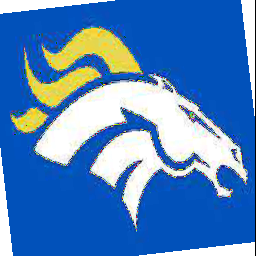

In [54]:
nparray = image_datasets['train'][12][0].cpu().numpy() 
image = transforms.ToPILImage()(image_datasets['train'][12][0].cpu()).convert("RGB")
display(image)

In [55]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_batches = 0
            outputs = None
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Loading Bar
                if (phase == 'train'):
                    num_batches += 1
                    percentage_complete = ((num_batches * batch_size) / (dataset_sizes[phase])) * 100
                    percentage_complete = np.clip(percentage_complete, 0, 100)
                    print("{:0.2f}".format(percentage_complete), "% complete", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # TODO: try removal
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                predicted = torch.max(outputs.data, 1)[1] 
                running_correct = (predicted == labels).sum()
                running_corrects += running_correct
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            
            epoch_acc = running_corrects / dataset_sizes[phase]
            #epoch_acc = sum(epoch_acc) / len(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc.item()))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [56]:
from torchvision import models
from torch.optim import lr_scheduler

model_ft = models.squeezenet1_1(pretrained=True)
model_ft.num_classes = 32 #this is am important compoent of the output model
model_ft.classifier._modules["1"] = nn.Conv2d(512, model_ft.num_classes, kernel_size=(1, 1))
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft.to(device), criterion, optimizer_ft, exp_lr_scheduler, 15)

Epoch 0/14
----------


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 206.8189 Acc: 0.0391
val Loss: 9.9802 Acc: 0.0938
Epoch 1/14
----------
train Loss: 159.2531 Acc: 0.0234
val Loss: 7.6000 Acc: 0.2188
Epoch 2/14
----------
train Loss: 79.3299 Acc: 0.0195
val Loss: 4.9371 Acc: 0.2812
Epoch 3/14
----------
train Loss: 21.1522 Acc: 0.0938
val Loss: 3.5036 Acc: 0.3125
Epoch 4/14
----------
train Loss: 2.6888 Acc: 0.4141
val Loss: 2.2878 Acc: 0.4062
Epoch 5/14
----------
train Loss: 1.8191 Acc: 0.5938
val Loss: 1.7701 Acc: 0.4688
Epoch 6/14
----------
train Loss: 1.2943 Acc: 0.7188
val Loss: 1.3828 Acc: 0.5938
Epoch 7/14
----------
train Loss: 1.0076 Acc: 0.7695
val Loss: 1.3290 Acc: 0.6250
Epoch 8/14
----------
train Loss: 1.0009 Acc: 0.7852
val Loss: 1.2691 Acc: 0.6250
Epoch 9/14
----------
train Loss: 0.9485 Acc: 0.7852
val Loss: 1.2447 Acc: 0.6562
Epoch 10/14
----------
train Loss: 0.8635 Acc: 0.8242
val Loss: 1.2506 Acc: 0.6562
Epoch 11/14
----------
train Loss: 0.8894 Acc: 0.8047
val Loss: 1.1966 Acc: 0.6562
Epoch 12/14
----------
train L

In [57]:
from sklearn.metrics import accuracy_score 
from PIL import Image as im


accuracy_scores = []
predicted = []
labels = []

running_corrects = 0
outputs = None
for inputs, labels in dataloaders['test']:
    model_ft.eval()
    

    inputs = inputs.to(device)
    labels = labels.to(device)
  
    outputs = model_ft(inputs)


    predicted = torch.max(outputs.data, 1)[1] 
    running_correct = (predicted == labels).sum()
    running_corrects += running_correct

accuracy = running_corrects / dataset_sizes['test']
print("Accuracy: " + str(accuracy.item()))

Accuracy: 0.75


In [58]:
y_test.value_counts()

ur_mom = ["Arizona Cardinals", "Atlanta Falcons", "Baltimore Ravens", "Buffalo Bills", "Carolina Panthers", "Chicago Bears", 
          "Cincinnati Bengals", "Cleveland Browns", "Dallas Cowboys", "Denver Broncos", "Detroit Lions", "Green Bay Packers", 
          "Houston Texans", "Indianapolis Colts", "Jacksonville Jaguars", "Kansas City Chiefs", "Las Vegas Raiders", 
          "Los Angeles Chargers", "Los Angeles Rams", "Miami Dolphins", "Minnesota Vikings", "New England Patriots", 
          "New Orleans Saints", "New York Giants", "New York Jets", "Philadephia Eagles", "Pittsburgh Steelers", 
          "San Francisco 49ers", "Seattle Seahawks", "Tampa Bay Buccaneers", "Tennessee Titans", "Washington Commanders"]

for i in range(0, len(labels)):
  print("Expected Result: ", ur_mom[labels[i]])
  print("         Predicted Result: ", ur_mom[predicted[i]])
  print()

Expected Result:  Green Bay Packers
         Predicted Result:  Green Bay Packers

Expected Result:  Los Angeles Rams
         Predicted Result:  Los Angeles Rams

Expected Result:  Baltimore Ravens
         Predicted Result:  Baltimore Ravens

Expected Result:  Tampa Bay Buccaneers
         Predicted Result:  San Francisco 49ers

Expected Result:  Seattle Seahawks
         Predicted Result:  Seattle Seahawks

Expected Result:  Philadephia Eagles
         Predicted Result:  Cleveland Browns

Expected Result:  Dallas Cowboys
         Predicted Result:  Cleveland Browns

Expected Result:  Minnesota Vikings
         Predicted Result:  Minnesota Vikings

Expected Result:  Las Vegas Raiders
         Predicted Result:  Las Vegas Raiders

Expected Result:  New York Giants
         Predicted Result:  New York Giants

Expected Result:  New Orleans Saints
         Predicted Result:  New Orleans Saints

Expected Result:  Denver Broncos
         Predicted Result:  Denver Broncos

Expected Result: 

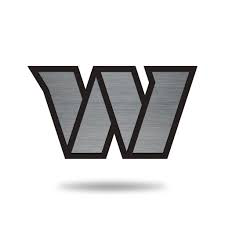

Washington Commanders


In [59]:
temp_X = ["/content/drive/MyDrive/DS_Project/TestMaterial.png"]
temp_y = [31]

display(Image.open(temp_X[0]))

hi = CustomDataset(temp_X, temp_y, 1, transform)
yoit = DataLoader(hi, batch_size=1, shuffle=True, num_workers=0)

for yo,yoyo in yoit:
  model_ft.eval()
  man = model_ft(yo.to(device))
  woman = torch.max(man.data, 1)[1]
  print(ur_mom[woman])

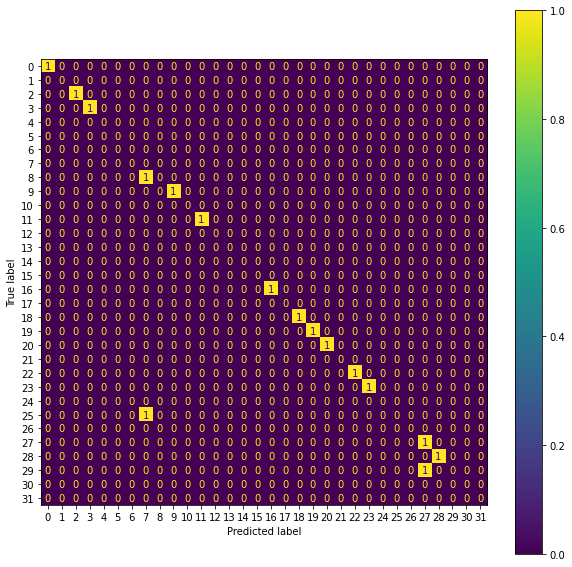

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

array = range(0,32)
cm = confusion_matrix(labels, predicted, labels=array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=array)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

